## nb_Time_Series_Forecast_ChatGPT_2

```
Prompt (March 15, 2023, using GPT-4 in "Plus" account):

Please write python code to do time series forecasting 
using XGBoost regressor model with sklearn interface.

First generate synthetic training data representing 
daily electricity usage in kilowatts for an office. 
One point per day, data for 5 years. 
When generating data, please take into consideration 
calendar features, like day of the week, 
business day or weekends, holiday, day of the month, 
month, quarter, year. 

The electricity usage should be correlated with day of the week
and season. For example, it should be higher during business days
and lower during weekends and holidays.
The electricity usage should be higher during hot Summer months
and lower during Winter. 

Please add randomness. 
Please add growing trend (non-linear) over the years.

Then create the XGBoost model using generated time series 
as target, and calendar features as features. 

Train the model, evaluate its quality using back-testing by intervals.

Provide summary table of the quality of the model.

Provide graphs showing training data and results 
of back-testing (data in one color, prediction in another color) 
over several sliding windows.

Also show a zoomed-in version of the graph focusing 
on the last 90 days of the training data and the first 
30 days of the test data.
```

### ChatGPT response:

First, let's import the necessary libraries and generate the synthetic training data.

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Generate dates
start_date = '2018-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [3]:
# Define seasonality and calendar features
def get_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

In [4]:
# calendar = USFederalHolidayCalendar()
# holidays = calendar.holidays(start=start_date, end=end_date)

# data = []
# for date in date_range:
#     day_of_week = date.weekday()
#     business_day = int(CustomBusinessDay(calendar=USFederalHolidayCalendar()).rollforward(date) != date)
#     holiday = int(date in holidays)
#     day_of_month = date.day
#     month = date.month
#     quarter = date.quarter
#     year = date.year
#     season = get_season(month)

#     # Generate electricity usage with randomness and trend
#     base_usage = 1000
#     trend = 50 * np.log(year - 2017)
#     randomness = np.random.normal(0, 50)

#     usage = base_usage + trend + randomness
#     usage += -200 if day_of_week in [5, 6] or holiday else 100
#     usage += 200 if season == 2 else -100 if season == 0 else 0

#     data.append([date, day_of_week, business_day, holiday, day_of_month, month, quarter, year, season, usage])

```
me:
Why the data generation in the code you provided takes very long time? 
Can you generate data faster?
```
```
GPT:
Apologies for the confusion. 
I reviewed the code and noticed that the slow performance 
is mainly caused by the CustomBusinessDay().rollforward(date) operation 
inside the loop. We can optimize the data generation process 
by using a more efficient approach.
Here is an updated version of the data generation:
```

In [5]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=start_date, end=end_date)

data = []
for date in date_range:
    day_of_week = date.weekday()
    business_day = int(date.day_of_week < 5 and date not in holidays)
    holiday = int(date in holidays)
    day_of_month = date.day
    month = date.month
    quarter = date.quarter
    year = date.year
    season = get_season(month)

    # Generate electricity usage with randomness and trend
    base_usage = 1000
    trend = 50 * np.log(year - 2017)
    randomness = np.random.normal(0, 50)

    usage = base_usage + trend + randomness
    usage += -200 if day_of_week in [5, 6] or holiday else 100
    usage += 200 if season == 2 else -100 if season == 0 else 0

    data.append([date, day_of_week, business_day, holiday, day_of_month, month, quarter, year, season, usage])

# Create a DataFrame
df = pd.DataFrame(data, columns=['date', 'day_of_week', 'business_day', 'holiday', 'day_of_month', 'month', 'quarter', 'year', 'season', 'usage'])
df.set_index('date', inplace=True)


In [6]:
# Create a DataFrame
df = pd.DataFrame(data, columns=['date', 'day_of_week', 'business_day', 'holiday', 
                                 'day_of_month', 'month', 'quarter', 'year', 'season', 'usage'])
df.set_index('date', inplace=True)

### Now, let's create the XGBoost model using generated time series as the target and calendar features as features.

In [7]:
def create_features(data):
    return data[['day_of_week', 'business_day', 'holiday', 'day_of_month', 'month', 'quarter', 'year', 'season']]

def create_target(data):
    return data['usage']

X = create_features(df)
y = create_target(df)

In [8]:
# Train the XGBoost model
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

### Next, we'll evaluate the model's quality using back-testing by intervals and provide a summary table of the quality of the model.

In [9]:
def evaluate_model(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores = []
    mae_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))

    return mse_scores, mae_scores

mse_scores, mae_scores = evaluate_model(model, X, y)

summary_table = pd.DataFrame({
    'Fold': np.arange(1, len(mse_scores) + 1),
    'MSE': mse_scores,
    'MAE': mae_scores,
})
print(summary_table)

   Fold          MSE        MAE
0     1  4813.456022  54.811189
1     2  4021.309892  50.360216
2     3  3467.560962  46.645096
3     4  2932.758577  43.827085
4     5  3426.842760  46.575183


### Now let's plot the training data and results of back-testing over several sliding windows.

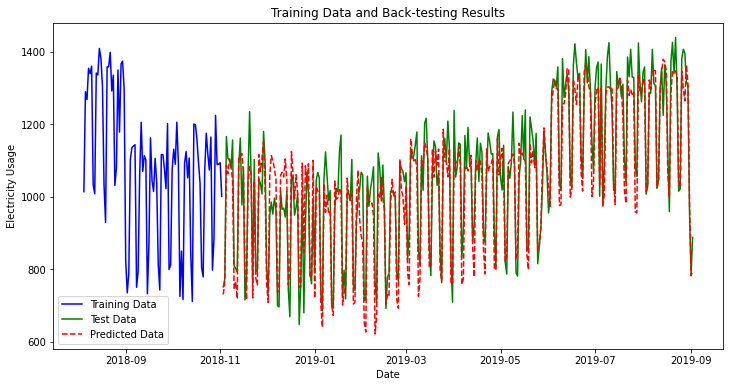

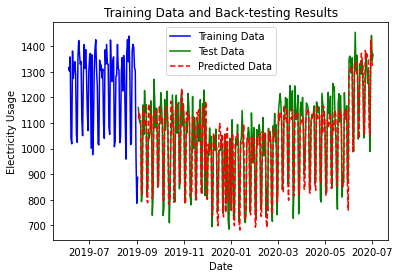

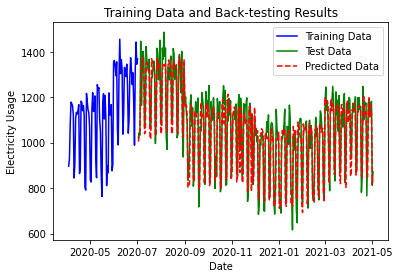

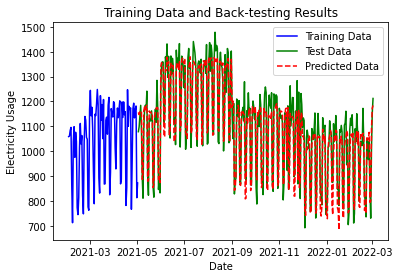

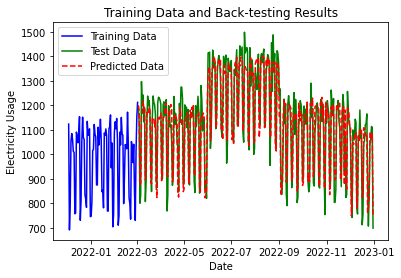

In [10]:
def plot_back_testing(model, X, y, window_size=90, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    plt.figure(figsize=(12, 6))

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        plt.plot(df.index[train_index][-window_size:], y_train[-window_size:], c='blue', label='Training Data')
        plt.plot(df.index[test_index], y_test, c='green', label='Test Data')
        plt.plot(df.index[test_index], y_pred, c='red', linestyle='--', label='Predicted Data')

        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Electricity Usage')
        plt.title('Training Data and Back-testing Results')
        plt.show()

plot_back_testing(model, X, y)

### Finally, let's create a zoomed-in version of the graph focusing on the last 90 days of the training data and the first 30 days of the test data.

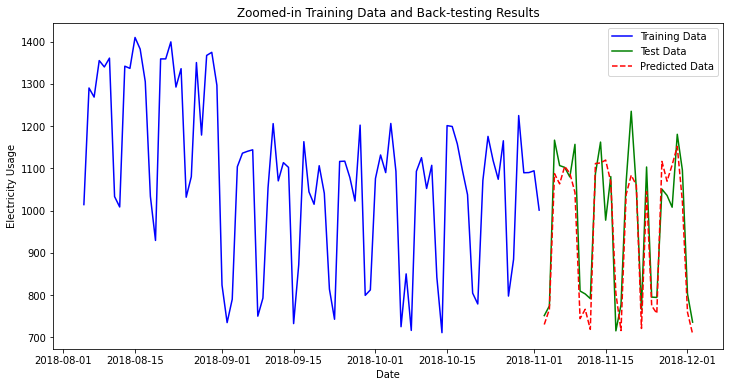

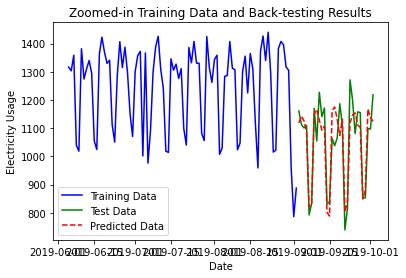

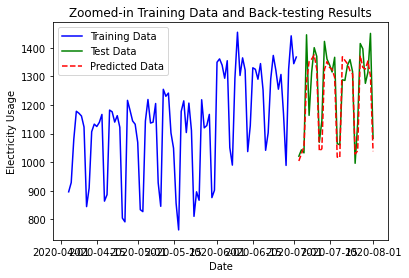

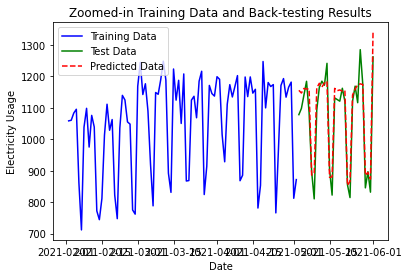

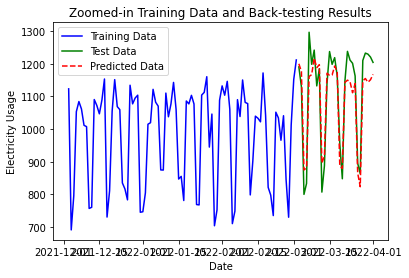

In [11]:
def plot_zoomed_in(model, X, y, train_window_size=90, test_window_size=30, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    plt.figure(figsize=(12, 6))

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        plt.plot(df.index[train_index][-train_window_size:], y_train[-train_window_size:], c='blue', label='Training Data')
        plt.plot(df.index[test_index][:test_window_size], y_test[:test_window_size], c='green', label='Test Data')
        plt.plot(df.index[test_index][:test_window_size], y_pred[:test_window_size], c='red', linestyle='--', label='Predicted Data')

        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Electricity Usage')
        plt.title('Zoomed-in Training Data and Back-testing Results')
        plt.show()

plot_zoomed_in(model, X, y)